In [1]:
import json
import pandas as pd
import numpy as np
import math
from statistics import NormalDist

import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

pd.options.display.float_format = '{:.2f}'.format

In [2]:
from code_rationales.taxonomies import *

### SETUP 

In [3]:
def param_default():
    return {
        'dataset' : 'code_completion_random_cut_5k_30_512_tokens',
        #'dataset' : 'code_completion_docstring_random_cut_3.8k_30_150_tokens',
        #'dataset' : 'code_completion_docstring_signature_3.8k_30_150_tokens',
        #'dataset' : 'code_completion_docstring_5k_30_150_tokens',
        'global_ast_results': '/workspaces/code-rationales/data/global_ast_results/gpt',
        'global_taxonomy_results': '/workspaces/code-rationales/data/global_taxonomy_results/gpt',
        'quantitative_results' : '/workspaces/code-rationales/data/quantitative_results',
        'groupings' : '/workspaces/code-rationales/data/groupings', 
        'num_experiments' : 30, 
        'bootstrapping_size': 500 ## question.. should be 500, change name
    }
params = param_default()

### Load Aggregation results

In [4]:
get_experiment_path =  lambda results_folder, dataset, exp: results_folder + '/' + dataset + '_exp_' + str(exp) +'.txt'


In [5]:
def get_experiments_results(results_folder):
    experiment_paths = [get_experiment_path(results_folder, params['dataset'], exp) for exp in range(params['num_experiments'])]
    experiment_global_results = []
    for experiment_path in experiment_paths:
        with open(experiment_path, 'r') as file:
            experiment_global_results.append(json.loads(file.read()))
    return experiment_global_results


### Dictionary Flatting

In [6]:
def flat_global_results(experiment_global_result: dict):
    flatten_results = { key: [] for key in experiment_global_result.keys() } ## There are 31 fixed categories
    for target_key, rationales in experiment_global_result.items():
        for rational_key, rational_values in rationales.items():
            flatten_results[rational_key] += rational_values
    return flatten_results

### Statistics

In [7]:
def bootstrapping( np_data, np_func, size ):
    """Create a bootstrap sample given data and a function
    For instance, a bootstrap sample of means, or mediands. 
    The bootstrap replicates are a long as the original size
    we can choose any observation more than once (resampling with replacement:np.random.choice)
    """
    
    #Cleaning NaNs
    #np_data_clean = np_data[ np.logical_not( np.isnan(np_data) ) ] 
    
    #The size of the bootstrap replicate is as big as size
    #Creating the boostrap replicates as long as the orignal data size
    #This strategy might work as imputation 
    bootstrap_repl = [ np_func( np.random.choice( np_data, size=len(np_data) ) ) for i in range( size ) ]
    
    #logging.info("Covariate: " + cov) #Empirical Mean
    #logging.info("Empirical Mean: " + str(np.mean(np_data_clean))) #Empirical Mean
    #logging.info("Bootstrapped Mean: " + str( np.mean(bootstrap_repl) ) ) #Bootstrapped Mean
    
    return np.array( bootstrap_repl )

In [8]:
def confidence_intervals_large_samples(data, confidence=0.95):
    """
    @confidence: confidence interval 
    @return: tuple (lowerbound, uperbound, h-value)
    """
    dist = NormalDist.from_samples( data )
    z = NormalDist().inv_cdf((1 + confidence) / 2.)
    h = dist.stdev * z / ((len(data) - 1) ** .5)
    return dist.mean - h, dist.mean + h, h

In [9]:
def boostrap_dictionary(dictionary: dict, size):
    boostrapped_dict = {}
    for key, values in dictionary.items():
        if values:
            boostrapped_dict[key] = bootstrapping(values, np.mean, size)
    return boostrapped_dict

### Data processing


In [10]:
def clean_results(global_results):
    def clean_dictonary(result_dict):
        clean_dict = result_dict.copy()
        for key, value in result_dict.items():
            if not value:
                clean_dict.pop(key)
        return clean_dict
    for key, value in global_results.items():
        global_results[key] = clean_dictonary(value)
    return clean_dictonary(global_results)

In [11]:
def get_experiments_dfs(experients_global_results):
    experiment_dfs = []
    for experiment in experients_global_results:
        experiment = flat_global_results(experiment)
        experiment = boostrap_dictionary(dictionary=experiment, size=params['bootstrapping_size'])
        experiment_dfs.append(pd.DataFrame(experiment))
    return experiment_dfs

In [12]:
### REDUCE EXPERIMENTS FOR HEATMAPS
def reduce_rationales_df(experients_global_results: dict, target_list: list, source_list: list):
    reduced_rationales_df = {target: {rational: [] for rational in source_list} for target in target_list}
    for experient_global_result in experients_global_results:
        target_dictionary = {key: value for key, value in experient_global_result.items() if key in target_list}
        for target_key in target_dictionary.keys():
            target_dictionary[target_key] = {key: np.median(bootstrapping(value, np.mean, 100)) # MEDIAN FOR EXPERIMENT RESULT
                                             for key, value in target_dictionary[target_key].items() if key in source_list}
            for rational_key in target_dictionary[target_key].keys():
                reduced_rationales_df[target_key][rational_key].append(target_dictionary[target_key][rational_key])
    for target_key in reduced_rationales_df.keys():
        reduced_rationales_df[target_key] = boostrap_dictionary(reduced_rationales_df[target_key], 100)
    return reduced_rationales_df         

### Grouping

In [13]:
def get_global_results_category_by_groups(experients_global_results: list):
    global_results_by_groups = [{} for _ in range(len(experients_global_results))]
    for exp_id, experiment_result in enumerate(experients_global_results):
        experiment = {category: {group: [] for group in global_groups().keys()} for category in experiment_result.keys()}
        for target_category in experiment_result.keys():
            for rational_category, rational_values in experiment_result[target_category].items():
                experiment[target_category][list(filter(lambda group: rational_category in global_groups()[group], global_groups().keys()))[0]] += rational_values
    for exp_id, experiment_result in enumerate(experients_global_results):
        global_results_by_groups[exp_id] = clean_results(experiment)
    return global_results_by_groups

In [14]:
def get_global_results_group_by_categories(experients_global_results: list):
    global_results_by_groups = [{} for _ in range(len(experients_global_results))]
    for exp_id, experiment_result in enumerate(experients_global_results):
        experiment = {group: {category: [] for category in experiment_result.keys()} for group in global_groups().keys()}
        for target_category in experiment_result.keys():
            for rational_category, rational_values in experiment_result[target_category].items():
                experiment[list(filter(lambda group: target_category in global_groups()[group], global_groups().keys()))[0]][rational_category] += rational_values
    for exp_id, experiment_result in enumerate(experients_global_results):
        global_results_by_groups[exp_id] = clean_results(experiment)
    return global_results_by_groups

In [15]:
def get_global_results_group_by_groups(experients_global_results: list):
    global_results_by_groups = [{} for _ in range(len(experients_global_results))]
    for exp_id, experiment_result in enumerate(experients_global_results):
        experiment = {group_target: {group_rational: [] for group_rational in global_groups().keys()} for group_target in global_groups().keys()}
        for target_category in experiment_result.keys():
            for rational_category, rational_values in experiment_result[target_category].items():
                experiment[list(filter(lambda group: target_category in global_groups()[group], global_groups().keys()))[0]][list(filter(lambda group: rational_category in global_groups()[group], global_groups().keys()))[0]] += rational_values
    for exp_id, experiment_result in enumerate(experients_global_results):
        global_results_by_groups[exp_id] = clean_results(experiment)
    return global_results_by_groups

### Visualization

In [16]:
def print_heatmap(
        experients_global_results: dict, 
        target_list: list, 
        source_list: list,
        ylabel: str, 
        xlabel: str,
        fig_size = (10,10), 
        font = 20, 
        vmax = 0.22
):
        reduced_rationales_global_results_df = pd.DataFrame(reduce_rationales_df(experients_global_results, target_list, source_list)).fillna(0)
        for column in reduced_rationales_global_results_df.columns:
                reduced_rationales_global_results_df[column] = reduced_rationales_global_results_df[column].apply(lambda value: np.median(value)) 

        cmap = LinearSegmentedColormap.from_list('custom_map', ['black','green'], N=128)
        #cmap = "YlGnBu"

        plt.rcParams.update({'font.size': font})
        ax = plt.axes()
        sns.set(rc = {'figure.figsize':fig_size})
        sns.heatmap(reduced_rationales_global_results_df, 
                    #cmap=cmap, 
                    vmin=0, vmax=vmax,
                    ax=ax)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show
        pass

### Analysis - Rational Concept - Countings

In [17]:
def create_frequencies_dataframe(experients_global_results: list):
    frequencies_df = pd.DataFrame(columns=experients_global_results[0].keys())
    for experiment_global_result in experients_global_results:
        rationales_results = flat_global_results(experiment_global_result)
        frequencies_df = frequencies_df.append({key: len(value) for key, value in rationales_results.items()}, ignore_index=True)
    frequencies_df = frequencies_df.fillna(0)   
    return frequencies_df


### Analysis - Rational Concept - Bootstrapping probability

In [18]:
# Function to fill NaN values with random chose from a specified array
def fill_nan_with_random_col(col):
    if col.isna().sum() == 0:
        return col
    random_values = np.random.choice(col[col.notna()].to_list(), col.isna().sum())
    col[col.isna()] = random_values
    return col

In [19]:
def create_bootstapped_dataframe(experients_global_results:list):
    bootstrapped_df = pd.DataFrame(columns=experients_global_results[0].keys())
    for experiment_global_result in experients_global_results:
        rationales_results = flat_global_results(experiment_global_result)
        rationales_results = boostrap_dictionary(dictionary=rationales_results, size=params['bootstrapping_size'])
        bootstrapped_df = bootstrapped_df.append({key: np.median(value) for key, value in rationales_results.items()}, ignore_index=True)
    return bootstrapped_df

### Calculate statistics and get results DF

In [20]:
### CREATE GROUP FREQUENCY RESULTS
def calculate_results(global_dataframe):
    results_df = pd.DataFrame(columns=['type', 'group', 'category', 'mean', 'median', 'std', 'ci'])
    for category in global_dataframe.columns:
        experiments_values = global_dataframe[category].tolist()
        try:
            group = [key for key, value in global_groups().items() if category in value][0] ## Mapping from taxonomy groups
        except Exception as e:
            print(e)
        results_df = results_df.append({
            'type': group.split('_')[0], 
            'group': group, 
            'category': category, 
            'median' : np.median(experiments_values),
            'mean' : np.mean(experiments_values), 
            'std' : np.std(experiments_values),
            'ci' : confidence_intervals_large_samples(experiments_values)
        }, ignore_index=True)
    return results_df.sort_values(by='median', ascending=False).reset_index(drop=True)

### Store Groupings

In [21]:
def store_groupings(global_results: list, name: str):
    with open(params['groupings'] + '/' + params['dataset'] + '_' + name + '.json', 'w') as output_file: 
        json.dump(global_results, output_file)

### Create Groupings

In [22]:
experiments_global_results = get_experiments_results(params['global_taxonomy_results'])
global_results_category_by_groups = get_global_results_category_by_groups(experiments_global_results)
global_results_group_by_categories = get_global_results_group_by_categories(experiments_global_results)
global_results_groups_by_groups = get_global_results_group_by_groups(experiments_global_results)

In [23]:
store_groupings(experiments_global_results, 'category_by_categories')
store_groupings(global_results_category_by_groups, 'category_by_groups')
store_groupings(global_results_group_by_categories, 'group_by_categories')
store_groupings(global_results_groups_by_groups, 'groups_by_groups')

### Frequency Analysis

In [24]:
global_frequencies_dataframe = create_frequencies_dataframe(experiments_global_results)
global_frequencies_dataframe

,punctuation,exceptions,oop,asserts,types,conditionals,loops,operators,indentation,bool,...,nl_pronoun,nl_adverb,nl_adjetive,nl_determiner,nl_preposition,nl_particle,nl_modal,nl_conjunction,nl_cardinal,nl_other
0,57459,0,884,142,9994,494,389,12328,70112,319,...,230,796,1516,944,620,46,58,51,278,1948
1,57404,0,833,154,13777,538,334,28103,70585,120,...,4,448,2291,443,283,17,100,0,112,1515
2,54684,0,1081,164,11323,345,340,11188,73160,111,...,233,712,1526,983,813,0,209,38,171,1877
3,54894,26,846,185,7616,556,482,11182,69258,139,...,162,751,1663,798,601,0,16,91,251,1944
4,51560,0,832,161,8112,463,278,10174,62376,114,...,15,703,994,662,650,5,73,0,51,1413
5,56659,0,857,146,10110,341,292,11754,69692,145,...,122,827,1751,998,385,0,21,5,460,1768
6,54774,91,838,179,12548,491,207,12178,67039,149,...,52,545,2307,735,665,0,15,44,181,2088
7,52937,16,808,236,7198,495,323,10447,65200,42,...,0,701,2329,585,474,0,33,40,217,2083
8,54514,31,983,153,7210,438,401,11198,69336,186,...,53,793,1799,567,739,0,71,71,134,2514
9,52919,18,864,131,9833,221,183,11458,69131,132,...,126,673,1989,1056,781,0,77,0,100,2072


In [25]:
global_frequencies_dataframe_results = calculate_results(global_frequencies_dataframe).sort_values(by=['group','mean'],ascending=[True, False])
global_frequencies_dataframe_results

,type,group,category,mean,median,std,ci
1,excluded,excluded,excluded,167989.90,169267.00,5230.66,"(166053.62496270405, 169926.17503729594, 1936...."
20,nl,nl_not_semantic,nl_adverb,830.53,799.50,218.65,"(749.595224138453, 911.4714425282136, 80.93810..."
21,nl,nl_not_semantic,nl_determiner,789.17,785.00,202.36,"(714.258491317266, 864.0748420160672, 74.90817..."
22,nl,nl_not_semantic,nl_preposition,708.83,683.00,198.10,"(635.4994366609212, 782.1672300057455, 73.3338..."
26,nl,nl_not_semantic,nl_cardinal,226.13,184.00,170.33,"(163.07944169998692, 289.1872249666797, 63.053..."
29,nl,nl_not_semantic,nl_modal,67.47,57.00,65.08,"(43.37497596592172, 91.55835736741162, 24.0916..."
31,nl,nl_not_semantic,nl_conjunction,46.10,39.00,43.07,"(30.157868553453334, 62.04213144654667, 15.942..."
33,nl,nl_not_semantic,nl_particle,4.50,0.00,10.66,"(0.5548090757639539, 8.445190924236046, 3.9451..."
5,nl,nl_semantic,nl_noun,76462.27,76162.50,2427.76,"(75563.56400231094, 77360.96933102238, 898.702..."
14,nl,nl_semantic,nl_verb,4252.47,4247.50,472.35,"(4077.6124958815344, 4427.320837451798, 174.85..."


In [26]:
global_frequencies_dataframe_results.to_csv(params['quantitative_results'] + '/' + params['dataset'] + '_frequencies' + '.csv', index=False)

### Rationales Analysis

In [27]:
global_bootstrapped_dataframe = create_bootstapped_dataframe(experiments_global_results)
global_bootstrapped_dataframe = global_bootstrapped_dataframe.apply(fill_nan_with_random_col, axis = 0) ## Imputation values, picking a random value from non nan
global_bootstrapped_dataframe

KeyboardInterrupt: 

In [ ]:
global_bootstrapped_dataframe_results = calculate_results(global_bootstrapped_dataframe).sort_values(by=['group','mean'],ascending=[True, False])
global_bootstrapped_dataframe_results

,type,group,category,mean,median,std,ci
13,excluded,excluded,excluded,0.06,0.06,0.00,"(0.0638736229004564, 0.0653347688163228, 0.000..."
25,nl,nl_not_semantic,nl_modal,0.06,0.05,0.04,"(0.04933286411151759, 0.07771148777437932, 0.0..."
21,nl,nl_not_semantic,nl_adverb,0.06,0.06,0.01,"(0.05213148901028458, 0.05860975093133715, 0.0..."
28,nl,nl_not_semantic,nl_cardinal,0.06,0.04,0.03,"(0.043587296889845625, 0.06694212794299886, 0...."
27,nl,nl_not_semantic,nl_preposition,0.05,0.05,0.01,"(0.043925145912072694, 0.053165134710058945, 0..."
29,nl,nl_not_semantic,nl_determiner,0.04,0.04,0.01,"(0.037150137180648427, 0.04228086203776764, 0...."
32,nl,nl_not_semantic,nl_conjunction,0.03,0.02,0.01,"(0.019815404909458788, 0.03054754071728267, 0...."
33,nl,nl_not_semantic,nl_particle,0.02,0.01,0.01,"(0.010404224295062815, 0.019967776110512977, 0..."
9,nl,nl_semantic,nl_noun,0.07,0.07,0.00,"(0.06477436077565098, 0.06630636645506509, 0.0..."
22,nl,nl_semantic,nl_verb,0.05,0.05,0.01,"(0.051683841714832444, 0.05554783729123882, 0...."


In [ ]:
global_bootstrapped_dataframe_results.to_csv(params['quantitative_results'] + '/' + params['dataset'] + '_bootstrapped' + '.csv', index=False)

### Heatmaps

In [30]:
experiments_global_results[0]['nl_noun']

{}

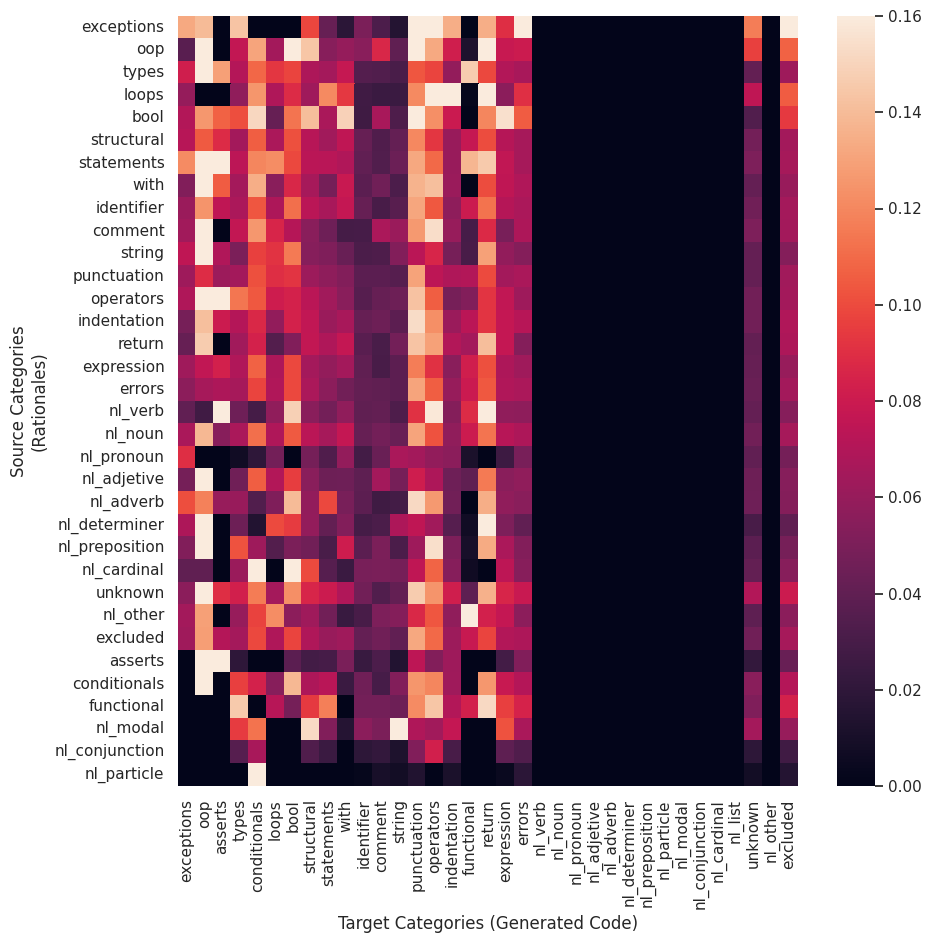

In [29]:
##### TARGET - CATEGORY ALL
##### SOURCE - CATEGORY ALL
target_elements = [category for categories in global_groups().values() for category in categories] #X
source_elements = [category for categories in global_groups().values() for category in categories] #Y
print_heatmap(experiments_global_results, target_list=target_elements, source_list=source_elements, xlabel='Target Categories (Generated Code)', ylabel='Source Categories\n(Rationales)', fig_size=(10,10), font=20, vmax=0.16)

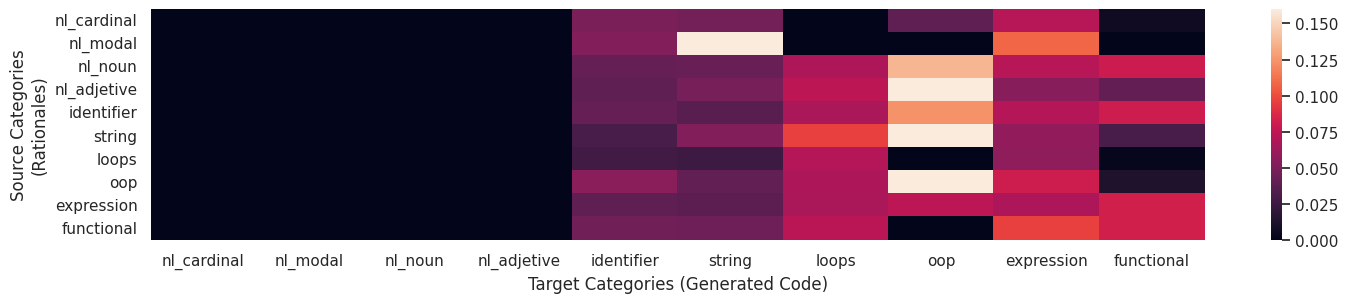

In [52]:
##### TARGET - CATEGORY 
##### SOURCE - CATEGORY
target_elements = ['nl_cardinal', 'nl_modal', 'nl_noun', 'nl_adjetive', 'identifier', 'string', 'loops', 'oop', 'expression', 'functional'] #X
source_elements = ['nl_cardinal', 'nl_modal', 'nl_noun', 'nl_adjetive', 'identifier', 'string', 'loops', 'oop', 'expression', 'functional'] #Y
print_heatmap(experiments_global_results, target_list=target_elements, source_list=source_elements, xlabel='Target Categories (Generated Code)', ylabel='Source Categories\n(Rationales)', fig_size=(100,100), vmax=0.16)

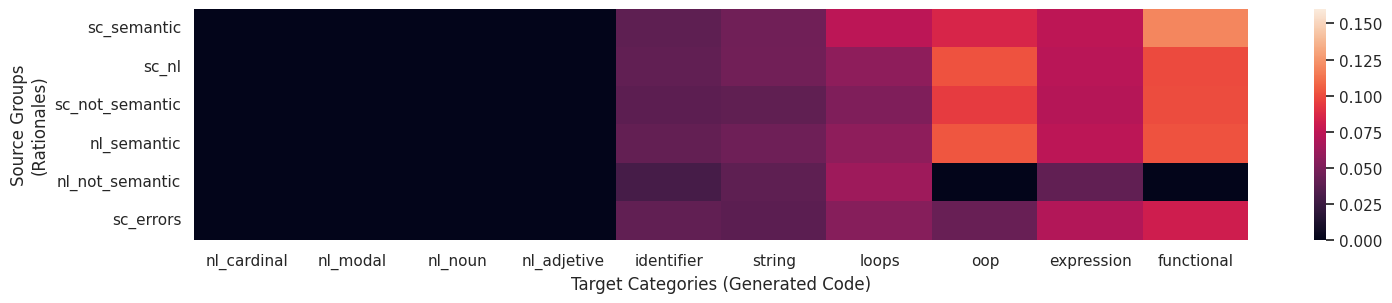

In [54]:
##### TARGET - CATEGORY 
##### SOURCE - GROUP
target_elements = ['nl_cardinal', 'nl_modal', 'nl_noun', 'nl_adjetive', 'identifier', 'string', 'loops', 'oop', 'expression', 'functional'] #X
source_elements = ['sc_semantic', 'sc_nl', 'sc_not_semantic', 'nl_semantic', 'nl_not_semantic', 'sc_errors'] #Y
print_heatmap(global_results_category_by_groups, target_list=target_elements, source_list=source_elements, xlabel='Target Categories (Generated Code)', ylabel='Source Groups\n(Rationales)', fig_size=(100,100), vmax=0.16)

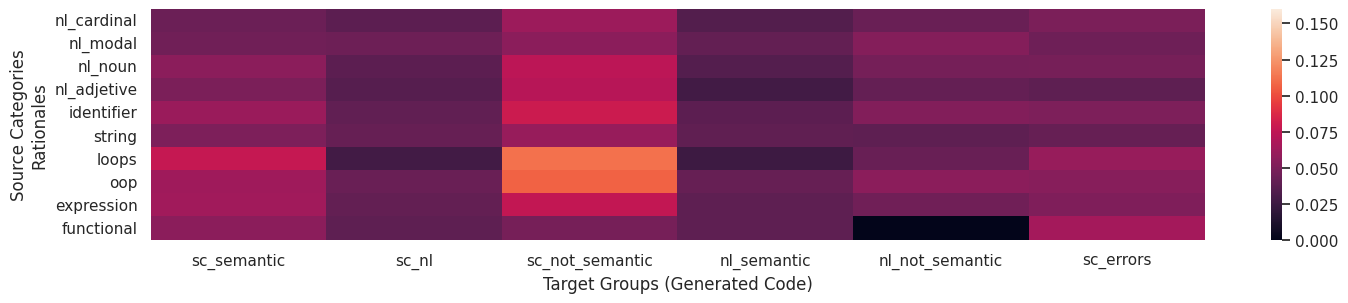

In [119]:
##### TARGET - GROUP 
##### SOURCE - CATEGORY
target_elements = ['sc_semantic', 'sc_nl', 'sc_not_semantic', 'nl_semantic', 'nl_not_semantic', 'sc_errors'] #X
source_elements = ['nl_cardinal', 'nl_modal', 'nl_noun', 'nl_adjetive', 'identifier', 'string', 'loops', 'oop', 'expression', 'functional'] #Y
print_heatmap(global_results_group_by_categories, target_list=target_elements, source_list=source_elements, xlabel='Target Groups (Generated Code)', ylabel='Source Categories\nRationales', fig_size=(17,3), vmax=0.16)

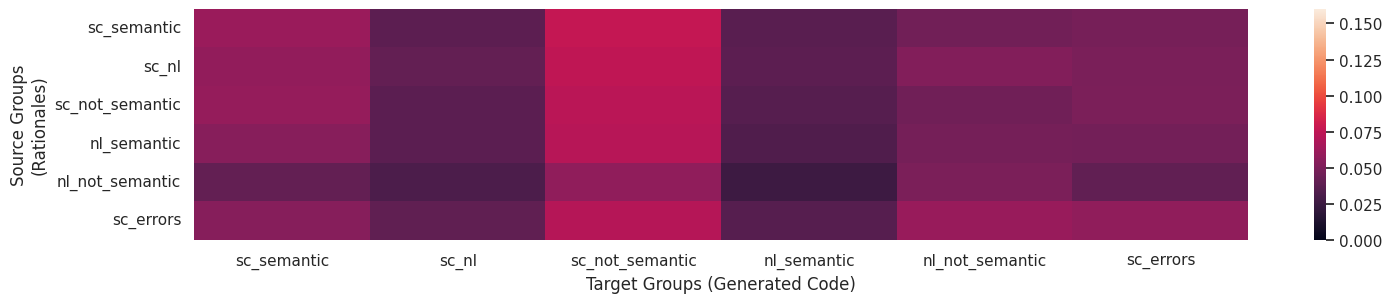

In [120]:
##### TARGET - GROUP 
##### SOURCE - GROUP
target_elements = ['sc_semantic', 'sc_nl', 'sc_not_semantic', 'nl_semantic', 'nl_not_semantic', 'sc_errors'] #X
source_elements = ['sc_semantic', 'sc_nl', 'sc_not_semantic', 'nl_semantic', 'nl_not_semantic', 'sc_errors'] #Y
print_heatmap(global_results_groups_by_groups, target_list=target_elements, source_list=source_elements, xlabel='Target Groups (Generated Code)', ylabel='Source Groups\n(Rationales)', fig_size=(17,3), vmax=0.16)